In [1]:

data = {
    'proj_file': '/home/ravescovi/Downloads/NSLS2/scan_00244/proj_00000.hdf',
    'angles_file': '/home/ravescovi/Downloads/NSLS2/scan_00244/scan_00244.nxs',
    'dark_file': '/home/ravescovi/Downloads/NSLS2/scan_00245/dark_00000.hdf',
    'flat_file': '/home/ravescovi/Downloads/NSLS2/scan_00245/flat_00000.hdf',
    'recon_init': 1000,
    'recon_end': 1512,
    'rot_center': None,
}


In [2]:
import h5py
import matplotlib.pyplot as plt
import tomopy

proj_file = data['proj_file']
flat_file = data['flat_file']
dark_file = data['dark_file']
angles_file = data['angles_file']
recon_init = data['recon_init']
recon_end = data['recon_end']
rot_center = data['rot_center']

def load_data(proj_file, flat_file, dark_file, angles_file):
    proj = h5py.File(proj_file, 'r')['entry']['data']['data'][:,recon_init:recon_end,:]
    print('proj', proj.shape, proj.dtype)

    flats = h5py.File(flat_file, 'r')['entry']['data']['data'][:,recon_init:recon_end,:]
    print('flats',flats.shape, flats.dtype)

    darks = h5py.File(dark_file, 'r')['entry']['data']['data'][:,recon_init:recon_end,:]
    print('darks',darks.shape, darks.dtype)

    theta = h5py.File(angles_file, 'r')['entry']['data']['rotation_angle'][:]
    theta = theta*3.141592653589793/180 #move to radians
    print('theta',theta.shape, theta.dtype)
    return proj, flats, darks, theta

def recon_data(proj, flats, darks, theta):
    # Set data collection angles as equally spaced between 0-180 degrees.
    proj = tomopy.normalize(proj, flats, darks)
    print('proj_norm',proj.shape, proj.dtype)

    # Set data collection angles as equally spaced between 0-180 degrees.
    rot_center = tomopy.find_center_vo(proj)
    print('rot_center',rot_center)

    ## log normalization
    proj = tomopy.minus_log(proj)
    print('proj_norm_ml',proj.shape, proj.dtype)

    recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec')
    recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)
    print('recon',recon.shape)
    return recon, proj, rot_center

proj, flats, darks, theta = load_data(proj_file, flat_file, dark_file, angles_file)
recon, proj, rot_center = recon_data(proj, flats, darks, theta)


proj (1801, 512, 3200) uint16
flats (50, 512, 3200) uint16
darks (20, 512, 3200) uint16
theta (1801,) float32
proj_norm (1801, 512, 3200) float32
rot_center 1609.25
proj_norm_ml (1801, 512, 3200) float32
recon (512, 3200, 3200)


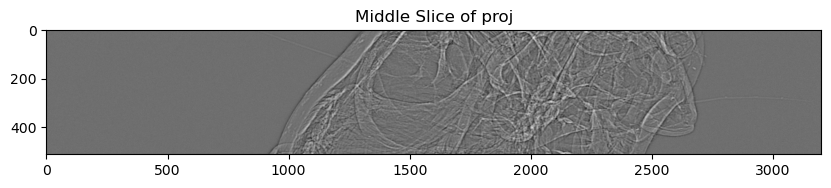

In [3]:
# Plot the middle slice of proj
fig, ax = plt.subplots(figsize=(10, 15))

ax.imshow(proj[proj.shape[0] // 2, :, :], cmap='gray')
ax.set_title('Middle Slice of proj')

plt.show()

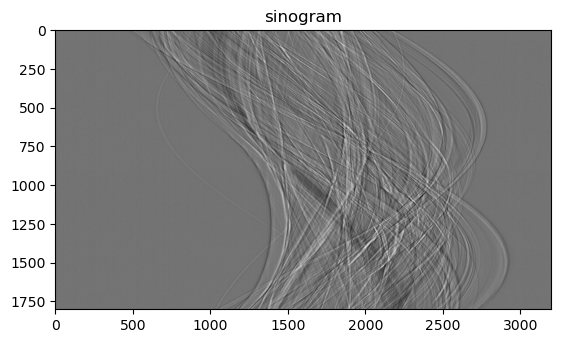

In [4]:
plt.imshow(proj[:, 0, :], cmap='gray')
plt.title('sinogram')
plt.show()

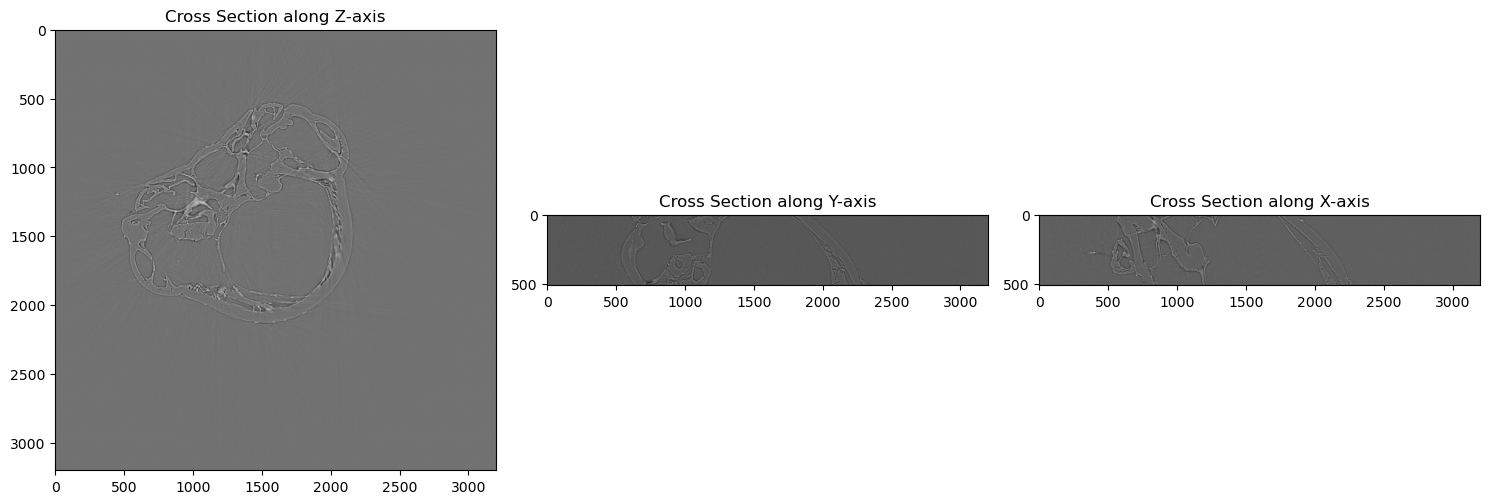

In [5]:
# Plot cross sections of tomo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the middle slice in each dimension
axes[0].imshow(recon[recon.shape[0] // 2, :, :], cmap='gray')
axes[0].set_title('Cross Section along Z-axis')

axes[1].imshow(recon[:, recon.shape[1] // 2, :], cmap='gray')
axes[1].set_title('Cross Section along Y-axis')

axes[2].imshow(recon[:, :, recon.shape[2] // 2], cmap='gray')
axes[2].set_title('Cross Section along X-axis')

plt.tight_layout()
plt.show()